In [ ]:
from pathlib import Path
import multiprocessing
import requests
import random

from datasets import load_dataset, Audio, Dataset, DatasetDict

import multiprocessing
from pathlib import Path
from collections import Counter

from transformers import SpeechT5Processor, pipeline
from datasets import DatasetDict, Audio, concatenate_datasets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio as IAudio
from IPython.display import display

from phonetic import text2phon

In [ ]:
n_cpu = multiprocessing.cpu_count()-5; print("CPU count:", n_cpu)
data_path = Path("/data/volume")
audio_path = data_path / "audio"
audio_path.mkdir(parents=True, exist_ok=True)

In [ ]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

## Load the dataset

In [ ]:
dataset_name = "openpecha/tts-training-filtered"
dataset = load_dataset(dataset_name)
dataset

In [ ]:
dataset["train"][100]["uni"]

## Filter Dataset

### Ignore Long Audio
Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [ ]:
dataset = concatenate_datasets([dataset["train"], dataset["test"]])

In [ ]:
def compute_tokens_len(item):
    tokens = processor.tokenizer.tokenize(item["sentence"])
    item["tokens_len"] = len(tokens)
    return item

dataset = dataset.map(compute_tokens_len, num_proc=n_cpu)

In [ ]:
dataset[0]["tokens_len"]

In [9]:
def plot_token_len_histogram(token_lengths):
    # Plotting the histogram
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.hist(token_lengths, bins=20, edgecolor='black')  # Create a histogram with 10 bins

    # Adding titles and labels
    plt.title('Histogram of Token Lengths')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')

    # Show the chart
    plt.show()

In [10]:
# plot_token_len_histogram(dataset["tokens_len"])

In [11]:
dataset = dataset.filter(lambda x: x["tokens_len"]<200, num_proc=n_cpu)
len(dataset)

621899

In [12]:
# plot_token_len_histogram(dataset["tokens_len"])

### Explore Department

In [13]:
seed = 42
ab_dataset = dataset.filter(lambda x: x["label"] == "STT_AB", num_proc=n_cpu).shuffle(seed=seed)
nw_dataset = dataset.filter(lambda x: x["label"] == "STT_NW", num_proc=n_cpu).shuffle(seed=seed)
hs_dataset = dataset.filter(lambda x: x["label"] == "STT_HS", num_proc=n_cpu).shuffle(seed=seed)
pc_dataset = dataset.filter(lambda x: x["label"] == "STT_PC", num_proc=n_cpu).shuffle(seed=seed)
ns_dataset = dataset.filter(lambda x: x["label"] == "STT_NS", num_proc=n_cpu).shuffle(seed=seed)

In [14]:
def explore(dataset_instance):
    i = random.choice(range(len(dataset_instance)))
    print(dataset[i]["label"])
    print(dataset[i]["uni"])
    print(dataset[i]["sentence"])
    print(dataset[i]["url"])

Audio Book

In [15]:
explore(ab_dataset)

STT_NW
གྲོང་ཁྱེར་ག་རེ་ཟེར་དགོས་རེད་ས་ཡ་ལྔ་ཡན་ལྡབ། ད་གཙོ་བོ་དེ་ཡིན་ན་པེ་ཅིང་དང་ཧྲང་ཧའེ་དེ་བ་ཕར་རྒྱ་ནག་གི་གྲོང་ཁྱེར་ཆེན་པོ་དེ་ཚོ་
grong khyer ga re zer dgos red sa ya lnga yan ldab/da gtso bo de yin na pe cing dang hrang ha'e de ba phar rgya nag gi grong khyer chen po de tsho
https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_NW0141_0037_216163_to_220932.wav


### Balance out Departments

In [16]:
def plot_department_dist(dataset):
    c = Counter(dataset["label"])
    print(c)
    labels = list(c.keys())
    sizes =  list(c.values()) # Percentages or absolute values
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', "#ffff99"]  # Optional colors

    # Create the pie chart
    plt.figure(figsize=(4, 4))  # Set the figure size
    plt.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',  # Show percentages with 1 decimal
        shadow=True,        # Add shadow effect
        startangle=140      # Rotate the start angle
    )

    # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')

    # Show the chart
    plt.title('Department')
    plt.show()

In [17]:
# plot_department_dist(dataset)

In [18]:
def get_balance_dataset(dataset, total, seed=42):
    ab_dataset = dataset.filter(lambda x: x["label"] == "STT_AB", num_proc=n_cpu).shuffle(seed=seed)
    nw_dataset = dataset.filter(lambda x: x["label"] == "STT_NW", num_proc=n_cpu).shuffle(seed=seed)
    hs_dataset = dataset.filter(lambda x: x["label"] == "STT_HS", num_proc=n_cpu).shuffle(seed=seed)
    pc_dataset = dataset.filter(lambda x: x["label"] == "STT_PC", num_proc=n_cpu).shuffle(seed=seed)
    ns_dataset = dataset.filter(lambda x: x["label"] == "STT_NS", num_proc=n_cpu).shuffle(seed=seed)

    ab_dataset = ab_dataset.select(range(total//5))
    nw_dataset = nw_dataset.select(range(total//5))
    hs_dataset = hs_dataset.select(range(total//5))
    pc_dataset = pc_dataset.select(range(total//5))
    ns_dataset = ns_dataset.select(range(total//5))

    ab_dataset = ab_dataset.train_test_split(test_size=0.2, seed=42)
    nw_dataset = nw_dataset.train_test_split(test_size=0.2, seed=42)
    hs_dataset = hs_dataset.train_test_split(test_size=0.2, seed=42)
    pc_dataset = pc_dataset.train_test_split(test_size=0.2, seed=42)
    ns_dataset = ns_dataset.train_test_split(test_size=0.2, seed=42)


    dataset = DatasetDict({
        "train": concatenate_datasets([ab_dataset["train"], nw_dataset["train"], hs_dataset["train"], pc_dataset["train"], ns_dataset["train"]]),
        "test": concatenate_datasets([ab_dataset["test"], nw_dataset["test"], hs_dataset["test"], pc_dataset["test"], ns_dataset["test"]])
    })

    return dataset

In [21]:
balanced_dataset = get_balance_dataset(dataset, total=30000)
len(balanced_dataset)

2

Counter({'STT_AB': 5000, 'STT_NW': 5000, 'STT_HS': 5000, 'STT_PC': 5000, 'STT_NS': 5000})


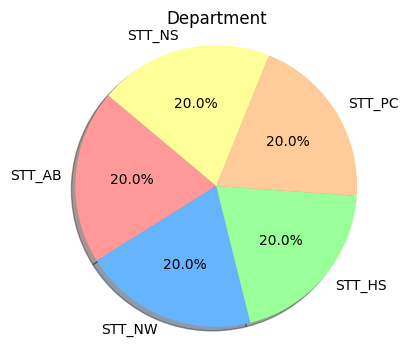

In [22]:
plot_department_dist(concatenate_datasets([balanced_dataset["train"], balanced_dataset["test"]]))

In [23]:
dataset = balanced_dataset

## Set Audio file path

In [25]:
def download_image(url, save_path):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Check for any HTTP errors
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
    except requests.exceptions.RequestException as e:
        raise e

def resolve_audio_path(item):
    file_name = f"{item['file_name']}.wav"
    local_path = audio_path / file_name
    if not local_path.is_file():
        if item["file_name"].startswith("STT_AB"):
            url = f"https://d38pmlk0v88drf.cloudfront.net/AB_wav16k_cleaned/{file_name}"
        else:
            url = item["url"]
        try:
            download_image(url, local_path)
        except:
            local_path = None

    item["path"] = str(local_path) if local_path else local_path
    del item["file_name"]
    del item["url"]

    return item

In [34]:
sample_ds = DatasetDict()

sample_ds["train"] = dataset["train"].select(range(1000)).map(resolve_audio_path, num_proc=n_cpu-1)
sample_ds["test"] = dataset["test"].select(range(200)).map(resolve_audio_path, num_proc=n_cpu)
print(len(sample_ds["train"]), len(sample_ds["test"]))
sample_ds = sample_ds.filter(lambda x: x["path"], num_proc=n_cpu)
print(len(sample_ds["train"]), len(sample_ds["test"]))

Map (num_proc=58):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=59):   0%|          | 0/200 [00:00<?, ? examples/s]

1000 200


Filter (num_proc=59):   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter (num_proc=59):   0%|          | 0/200 [00:00<?, ? examples/s]

997 199


In [35]:
sample_ds["train"][0]

{'uni': 'མེད་བློ་གྲོས་མིག་གིས་ལེགས་མཐོང་ཞིང་།',
 'sentence': 'med blo gros mig gis legs mthong zhing /',
 'label': 'STT_AB',
 'speaker_id': 'd294321b-2eae-491f-b992-b76d22f94449',
 'duration': 2.372,
 'tokens_len': 41,
 'path': '/data/volume/audio/STT_AB00596_0031_122192_to_124564.wav'}

## Filter music audio

In [36]:
audio_classifier = pipeline("audio-classification", model="MarekCech/GenreVim-Music-Detection-DistilHuBERT", device=0)

In [37]:
def is_music(batch_path):
    audio_arrays = [path["array"] for path in batch_path]
    results = audio_classifier(audio_arrays)  # Assuming `audio_classifier` supports batch input

    # Create a boolean list for filtering: True if 'Music' label > 0.99, False otherwise
    is_music_flags = []
    for result in results:
        is_music = any(label["label"] == "Music" and label["score"] > 0.99 for label in result)
        is_music_flags.append(is_music)

    return is_music_flags

def is_not_music(batch_path):
    audio_arrays = [path["array"] for path in batch_path]
    results = audio_classifier(audio_arrays)  # Assuming `audio_classifier` supports batch input

    # Create a boolean list for filtering: True if 'Music' label > 0.99, False otherwise
    is_not_music_flags = []
    for result in results:
        is_not_music = any(label["label"] == "Non Music" and label["score"] > 0.99 for label in result)
        is_not_music_flags.append(is_not_music)

    return is_not_music_flags

### Sample

In [38]:
sample_ds["train"] = sample_ds["train"].cast_column("path", Audio(sampling_rate=16000))
sample_ds["test"] = sample_ds["test"].cast_column("path", Audio(sampling_rate=16000))

In [39]:
music_sample_xs = sample_ds.filter(is_music, batched=True, batch_size=64, input_columns="path")
music_sample_xs

Parameter 'function'=<function is_music at 0x7fa101aa2ca0> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Filter:   0%|          | 0/997 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Filter:   0%|          | 0/199 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 4
    })
    test: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 1
    })
})

In [40]:
not_music_sample_xs = sample_ds.filter(is_not_music, batched=True, batch_size=64, input_columns="path")
not_music_sample_xs

Filter:   0%|          | 0/997 [00:00<?, ? examples/s]

Filter:   0%|          | 0/199 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 983
    })
    test: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 196
    })
})

In [41]:
def show(item):
    print(item["uni"])
    display(IAudio(item["path"]["array"], rate=16000))

In [42]:
for item in music_sample_xs["train"]:
    print(item["label"])
    show(item)

STT_AB
དེས་ན་རྩོད་པ་མི་འབྱུང་སྟེ།


STT_AB
ངག་རྣམས་རིག་བྱེད་ནི་ངག་སྒྲ།


STT_AB
ན་དང་མི་ན་ཀུན་གྱིས་ཀྱང་།


STT_AB
མ་ནུས་པ་ལ་གནང་བ་དང་།


In [43]:
for item in music_sample_xs["test"]:
    print(item["label"])
    show(item)

STT_AB
མིག་ཤེས་རང་དུས་ན་འདས་པའི་ཡིད་གཉིས་ཀ་ཡིན།


In [44]:
sample_ds

DatasetDict({
    train: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 997
    })
    test: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 199
    })
})

<!-- loaded_ds = DatasetDict.load_from_disk(dataset_path)
loaded_ds -->

### Add Phonetic

Instead of Wylie (which is used in previous experiments) use simple phonetic

In [45]:
sample_ds = not_music_sample_xs

In [46]:
def add_phonetic(item):
    phon = text2phon(item["uni"])
    item["sentence"] = phon
    return item

In [47]:
sample_ds = sample_ds.map(add_phonetic, num_proc=n_cpu)
sample_ds["train"][0]

Map (num_proc=59):   0%|          | 0/983 [00:00<?, ? examples/s]

couldn't understand syllable དབྱིབས
couldn't understand syllable པརཉེ
couldn't understand syllable པརཉེ
couldn't understand syllable ཏཱ
couldn't understand syllable ཏཱ
couldn't understand syllable དབྱིབས
couldn't understand syllable དགོསཞེས
couldn't understand syllable དགོསཞེས
couldn't understand syllable ཧཱ
couldn't understand syllable ཧཱ
couldn't understand syllable པཱ
couldn't understand syllable པཱ
couldn't understand syllable ཤཱཀྱ
couldn't understand syllable ཤཱཀྱ
couldn't understand syllable གཱ
couldn't understand syllable གཱ
couldn't understand syllable ཧིནྡུའི
couldn't understand syllable ཧིནྡུའི
couldn't understand syllable བཱིའི
couldn't understand syllable བཱིའི
couldn't understand syllable ཀླུའིརིགས
couldn't understand syllable ཀླུའིརིགས
couldn't understand syllable བོསྚོན
couldn't understand syllable བོསྚོན
couldn't understand syllable སཾ
couldn't understand syllable སཾ
couldn't understand syllable བྲཾ
couldn't understand syllable བྲཾ
couldn't understand syllable ཙཱ
couldn

Map (num_proc=59):   0%|          | 0/196 [00:00<?, ? examples/s]

couldn't understand syllable ནཱ
couldn't understand syllable ནཱ
couldn't understand syllable ཊཱིཀ
couldn't understand syllable ཊཱིཀ
couldn't understand syllable བསྒྲིབས
couldn't understand syllable མརྒ

couldn't understand syllable མརྒcouldn't understand syllable མཉྫི
couldn't understand syllable མཉྫི
couldn't understand syllable ཎི
couldn't understand syllable ཎི
couldn't understand syllable པོགཉིས
couldn't understand syllable པོགཉིས
couldn't understand syllable མཎྜལ
couldn't understand syllable མཎྜལ


{'uni': 'མེད་བློ་གྲོས་མིག་གིས་ལེགས་མཐོང་ཞིང་།',
 'sentence': 'mè  lo  ṭö  mik  ki  lèk  tong  shing',
 'label': 'STT_AB',
 'speaker_id': 'd294321b-2eae-491f-b992-b76d22f94449',
 'duration': 2.372,
 'tokens_len': 41,
 'path': {'path': '/data/volume/audio/STT_AB00596_0031_122192_to_124564.wav',
  'array': array([ 1.98364258e-04,  7.62939453e-05, -7.62939453e-05, ...,
          2.27355957e-03,  1.83105469e-03,  1.75476074e-03]),
  'sampling_rate': 16000}}

In [48]:
dataset_path = data_path / "tts-training-processed-sample-phono"
sample_ds.save_to_disk(dataset_path)

Saving the dataset (0/1 shards):   0%|          | 0/983 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/196 [00:00<?, ? examples/s]

In [49]:
loaded_sample_dataset = DatasetDict.load_from_disk(dataset_path)
loaded_sample_dataset["train"][0]

{'uni': 'མེད་བློ་གྲོས་མིག་གིས་ལེགས་མཐོང་ཞིང་།',
 'sentence': 'mè  lo  ṭö  mik  ki  lèk  tong  shing',
 'label': 'STT_AB',
 'speaker_id': 'd294321b-2eae-491f-b992-b76d22f94449',
 'duration': 2.372,
 'tokens_len': 41,
 'path': {'path': 'STT_AB00596_0031_122192_to_124564.wav',
  'array': array([ 1.98364258e-04,  7.62939453e-05, -7.62939453e-05, ...,
          2.27355957e-03,  1.83105469e-03,  1.75476074e-03]),
  'sampling_rate': 16000}}

## Process All

In [50]:
ds = balanced_dataset
ds = concatenate_datasets([ds["train"], ds["test"]])

In [51]:
print("#"*200)
print("[INFO] Processing all dataset,", len(ds))

########################################################################################################################################################################################################
[INFO] Processing all dataset, 25000


In [52]:
# download audio files
ds = ds.map(resolve_audio_path, num_proc=n_cpu)
ds = ds.filter(lambda x: x["path"], num_proc=n_cpu)

Map (num_proc=59):   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter (num_proc=59):   0%|          | 0/25000 [00:00<?, ? examples/s]

In [53]:
# load audio
ds = ds.cast_column("path", Audio(sampling_rate=16000))

In [54]:
# filter out music audio
print("[INFO] Filtering non-music audio...")
ds = ds.filter(is_not_music, batched=True, batch_size=128, input_columns="path")
print("[INFO] Dataset size:", len(ds))

[INFO] Filtering non-music audio...


Filter:   0%|          | 0/24991 [00:00<?, ? examples/s]

[INFO] Dataset size: 23919


In [55]:
ds = get_balance_dataset(ds, total=25000)

Filter (num_proc=59):   0%|          | 0/23919 [00:00<?, ? examples/s]

Filter (num_proc=59):   0%|          | 0/23919 [00:00<?, ? examples/s]

Filter (num_proc=59):   0%|          | 0/23919 [00:00<?, ? examples/s]

Filter (num_proc=59):   0%|          | 0/23919 [00:00<?, ? examples/s]

Filter (num_proc=59):   0%|          | 0/23919 [00:00<?, ? examples/s]

Counter({'STT_AB': 4000, 'STT_NW': 4000, 'STT_HS': 4000, 'STT_PC': 4000, 'STT_NS': 4000})


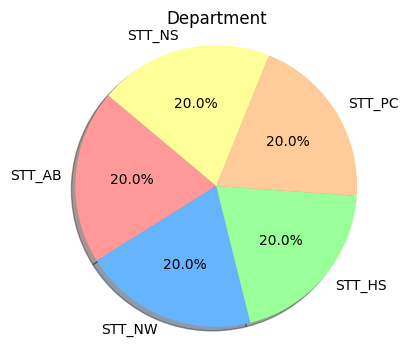

In [59]:
plot_department_dist(concatenate_datasets([d for d in ds.values()]))

In [ ]:
# add phono
ds = ds.map(add_phonetic, num_proc=n_cpu)

Map (num_proc=59):   0%|          | 0/16000 [00:00<?, ? examples/s]

couldn't understand syllable ཊོ
couldn't understand syllable ཊོ
couldn't understand syllable ཏཱ
couldn't understand syllable ཏཱ
couldn't understand syllable ཏཱ
couldn't understand syllable ཏཱ
couldn't understand syllable ནེཧ
couldn't understand syllable ནེཧ
couldn't understand syllable བྷ
couldn't understand syllable བྷ
couldn't understand syllable བྷ
couldn't understand syllable བྷ
couldn't understand syllable དྷ
couldn't understand syllable དྷ
couldn't understand syllable ཏཱ
couldn't understand syllable ཏཱ
couldn't understand syllable ནཱ
couldn't understand syllable ནཱ
couldn't understand syllable ཏཱ
couldn't understand syllable ཏཱ
couldn't understand syllable ཁཱང
couldn't understand syllable ཁཱང
couldn't understand syllable ཋི
couldn't understand syllable ཋི
couldn't understand syllable སཾ
couldn't understand syllable སཾ
couldn't understand syllable བྷུ
couldn't understand syllable བྷུ
couldn't understand syllable ཊའི
couldn't understand syllable ཊའི
couldn't understand syllable སྭར

In [ ]:
# save dataset
dataset_path = data_path / "tts-training-20k-processed-phono-"
ds.save_to_disk(dataset_path)